In [28]:
import pandas as pd

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [72]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')

# How many records in Jan data?

In [73]:
len1 = len(df)

In [74]:
df.columns

Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number'],
      dtype='object')

# Average duration in minutes

In [75]:
df['duration'] = df['dropOff_datetime'] - df['pickup_datetime']
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [76]:
df['duration'].mean()

19.1672240937939

# Data Preparation 

In [77]:
df['duration'].describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

In [78]:
df.duration.describe(percentiles=[0.1, 0.9, 0.95, 0.99])

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
10%      4.333333e+00
50%      1.340000e+01
90%      3.563333e+01
95%      4.725000e+01
99%      9.030000e+01
max      4.233710e+05
Name: duration, dtype: float64

In [79]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

/Users/pandabaka/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

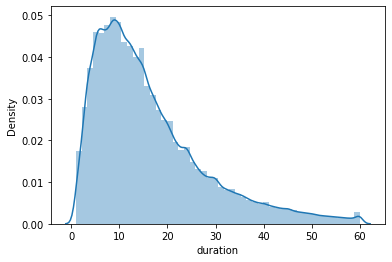

In [80]:
sns.distplot(df.duration)

 ## How many records did we drop to have only the records where the duration was between 1 and 60 minutes (inclusive)?

In [81]:
len1 - len(df)

44286

# Missing values

In [82]:
df.isnull().sum(axis = 0)

dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID               927008
DOlocationID               147907
SR_Flag                   1109826
Affiliated_base_number        773
duration                        0
dtype: int64

In [83]:
missing = df.isnull().sum(axis = 0)['PUlocationID']

In [84]:
missing

927008

In [85]:
df['PUlocationID'] = df['PUlocationID'].fillna(-1)

In [86]:
missing * 100 / len(df)

83.52732770722618

In [87]:
df.isnull().sum(axis = 0)

dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID                    0
DOlocationID               147907
SR_Flag                   1109826
Affiliated_base_number        773
duration                        0
dtype: int64

# One-hot encoding

In [101]:
# we'll use 2 features
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)
df[categorical].head()

,PUlocationID,DOlocationID
0,-1.0,nan
1,-1.0,nan
3,-1.0,72.0
4,-1.0,61.0
5,-1.0,71.0


In [113]:
# Turn the dataframe into a list of dictionaries
train_dicts = df[categorical].to_dict(orient='records')

In [114]:
train_dicts[:10]

[{'PUlocationID': '-1.0', 'DOlocationID': 'nan'},
 {'PUlocationID': '-1.0', 'DOlocationID': 'nan'},
 {'PUlocationID': '-1.0', 'DOlocationID': '72.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '61.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '71.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '91.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '39.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '37.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '39.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '72.0'}]

# Train a model

In [116]:
# Fit a dictionary vectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)


In [117]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519107211745

# Evaluate a model using next month's data

In [120]:
df_val = pd.read_parquet('./data/fhv_tripdata_2021-02.parquet')
df_val['duration'] = df_val['dropOff_datetime'] - df_val['pickup_datetime']
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]
df_val['PUlocationID'] = df_val['PUlocationID'].fillna(-1)

In [121]:
categorical = ['PUlocationID', 'DOlocationID']
df_val[categorical] = df_val[categorical].astype(str)
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [122]:
target = 'duration'
# y_train = df_train[target].values
y_val = df_val[target].values

In [123]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.014283208439476

/Users/pandabaka/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pandabaka/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


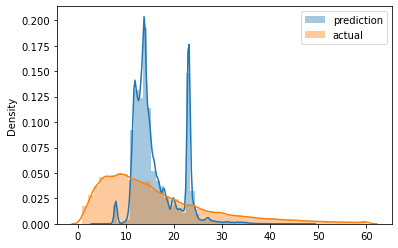

In [124]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()